In [1]:
# import imageio
import json
import torch
from viz.plots import plot_point_cloud_batch, plot_voxels_batch
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cpu')

def img_plot(img):
    if img.shape[0] == 1:
        plt.imshow(img[0], cmap='gray', vmin=0, vmax=1)
    else:
        plt.imshow(img.numpy().transpose(1, 2, 0), vmin=0, vmax=1)

## Load trained model

You will need to download the trained models before running this script (see README for download instructions).

In [6]:
from data.conversion import GridDataConverter, PointCloudDataConverter
# Note that this import is necessary for load_function_distribution
# properly instantiate the FourierFeatures
from models.function_representation import FourierFeatures  
from models.function_distribution import load_function_distribution


exp_dir = '2023-05-30_11-07_celebahq128_experiment'

with open(exp_dir + '/config.json') as f:
    config = json.load(f)

# Create appropriate data converter based on config
if config["dataset"] == 'mnist':
    data_shape = (1, config["resolution"], config["resolution"])
    data_converter = GridDataConverter(device, data_shape, 
                                       normalize_features=True)
elif config["dataset"] == 'celebahq':
    data_shape = (3, config["resolution"], config["resolution"])
    data_converter = GridDataConverter(device, data_shape, 
                                       normalize_features=True)
elif config["dataset"] == 'shapenet_voxels':
    data_shape = (1, config["resolution"], config["resolution"], config["resolution"])
    data_converter = GridDataConverter(device, data_shape, 
                                       normalize_features=True)
elif config["dataset"] == 'shapenet_point_clouds':
    data_shape = (1, config["resolution"], config["resolution"], config["resolution"])
    data_converter = PointCloudDataConverter(device, data_shape, 
                                       normalize_features=True)

# Load function distribution weights
func_dist = load_function_distribution(device, exp_dir + '/model.pt')

KeyError: 'input_dim'

In [3]:
print(func_dist)

FunctionDistribution(
  (hypernetwork): HyperNetwork(
    (function_representation): FunctionRepresentation(
      (encoding): FourierFeatures()
      (non_linearity): LeakyReLU(negative_slope=0.1)
      (final_non_linearity): Tanh()
      (forward_layers): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.1)
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): LeakyReLU(negative_slope=0.1)
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): LeakyReLU(negative_slope=0.1)
        (6): Linear(in_features=128, out_features=3, bias=True)
        (7): Tanh()
      )
    )
    (non_linearity): LeakyReLU(negative_slope=0.1)
    (forward_layers): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
      (4): 

## Sample from model

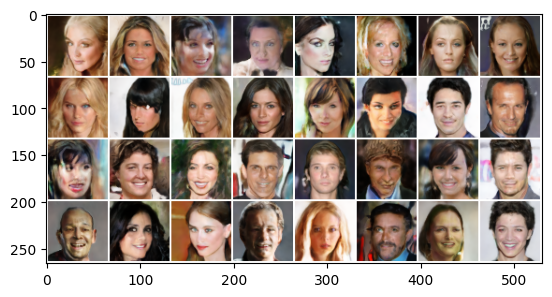

In [4]:
samples = func_dist.sample_data(data_converter, num_samples=32)
# Convert list of samples to batch of samples
samples = torch.cat([sample.unsqueeze(0) for sample in samples], dim=0).detach()
img_grid = make_grid(samples, nrow=8, pad_value=1.)
img_plot(img_grid)

## Superresolution

Since we can evaluate each sampled function at arbitrary coordinates, we can also use the model for superresolution.

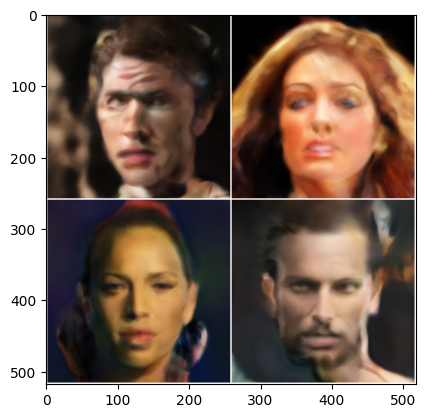

In [5]:
resolution = 256
samples = func_dist.sample_data(data_converter, num_samples=4, 
                                resolution=(resolution,) * 2)
samples = torch.cat([sample.unsqueeze(0) for sample in samples], dim=0).detach()
img_grid = make_grid(samples, nrow=2, pad_value=1.)
img_plot(img_grid)